In [1]:
import warnings
%load_ext autoreload
%autoreload 2
warnings.simplefilter('ignore')

"chr=conceded-home-rolling"
"car=conceded-away-rolling"
"hr=home-rolling"
"ar=away-rolling"


In [58]:
from preprocess import pack
from features import Features, feature_selection
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import optimization
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import numpy as np


feat = Features(**pack)
data = feat.execute()
container = feature_selection(data)
trainx = container.trainx
trainy = container.trainy
# best_params = optimization.optimizer(trainx, trainy, 'XGBoost_classif')


In [65]:
model = XGBClassifier(random_state=0, booster='gbtree', tree_method='hist',
                      eval_metric='mlogloss', verbosity=0, **best_params)


def train(trainx, trainy):
    folds = 10
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=0)
    train_acc, val_acc = [], []

    for k, (train_idx, val_idx) in enumerate(skf.split(trainx, trainy)):
        model.fit(trainx.iloc[train_idx].values, trainy.iloc[train_idx].values)
        train_preds = model.predict(trainx.iloc[train_idx].values)
        val_preds = model.predict(trainx.iloc[val_idx].values)

        acc_t = accuracy_score(
            y_true=trainy.iloc[train_idx].values, y_pred=train_preds)
        acc_v = accuracy_score(
            y_true=trainy.iloc[val_idx].values, y_pred=val_preds)
        train_acc.append(acc_t)
        val_acc.append(acc_v)
    return np.mean(train_acc), np.mean(val_acc)


In [79]:
best_params


OrderedDict([('colsample_bytree', 1.0),
             ('learning_rate', 0.14006304478391782),
             ('max_depth', 2),
             ('n_estimators', 50),
             ('subsample', 1.0)])

In [78]:
import features
best = features.auto_best_features(trainx, trainy, n_features=30)
best.head(5)


,pca_ftg_hr,p_chr,p_ar,p_hr,p_car,ftg_ar,hp_chr,ftg_hr,ftg_chr,hp_car,...,pca_htg_chr,s_car,st_car,st_ar,st_hr,pca_htg_hr,c_car,c_hr,c_chr,pca_f_ar
0,8.866708,3.000000,1.7,1.000000,1.1,2.1,2.666667,0.666667,2.833333,1.3,...,3.303819,9.3,5.2,5.7,3.666667,5.030941,4.8,4.166667,7.000000,-0.232326
1,2.174440,0.833333,1.7,0.500000,2.0,1.5,1.166667,1.000000,1.000000,2.1,...,1.884768,13.4,6.3,5.3,3.166667,0.100927,5.7,3.166667,6.166667,0.265277
2,2.516089,2.000000,1.3,2.166667,0.5,1.6,1.666667,2.500000,1.333333,1.0,...,-0.960373,9.7,3.2,4.4,5.500000,0.548668,5.3,4.166667,4.666667,0.656154
3,3.097088,1.500000,1.2,1.500000,0.4,1.1,1.500000,1.500000,0.500000,0.6,...,-2.715519,7.9,4.5,5.4,4.166667,-1.903942,5.1,5.000000,4.333333,0.962468
4,2.283887,0.333333,1.3,0.166667,1.3,1.0,0.500000,0.833333,0.666667,0.8,...,0.124077,11.8,4.7,4.5,3.333333,-3.492375,6.4,4.333333,3.833333,0.014202


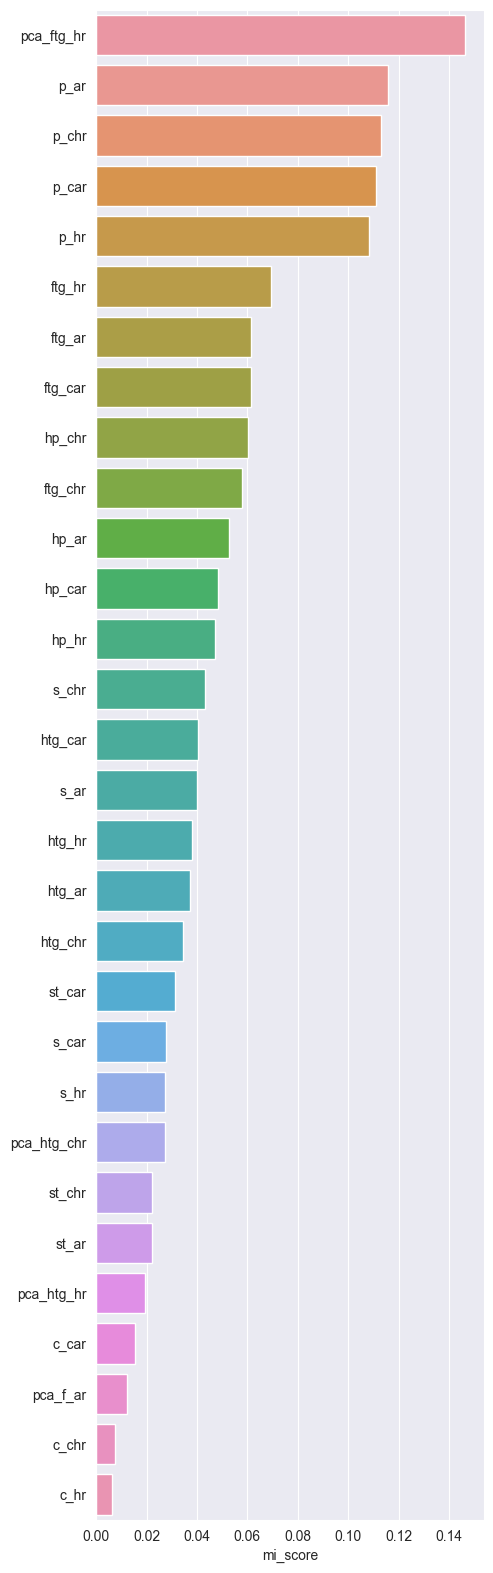

In [76]:
mi = features.mutual_information(best, trainy)
features.plotmi(mi)


In [80]:
train(best, trainy)

(0.601399436138519, 0.5906642075022)

In [86]:
from sklearn.metrics import confusion_matrix
preds=model.predict(best)
confusion_matrix(preds,trainy)

array([[1662,  510,  727],
       [ 724, 3263, 1273],
       [  31,   30,   69]])

In [89]:
pd.Series(preds).value_counts()

1    5260
0    2899
2     130
dtype: int64

In [91]:
trainy.value_counts()

1    3803
0    2417
2    2069
Name: ftr, dtype: int64

In [92]:

trainy

0       1
1       1
2       0
3       2
4       1
       ..
8284    0
8285    1
8286    1
8287    2
8288    1
Name: ftr, Length: 8289, dtype: int64

In [101]:
import pandas as pd
y_strat = pd.cut(trainy,bins=10, labels=False)
y_strat

0       4
1       4
2       0
3       9
4       4
       ..
8284    0
8285    4
8286    4
8287    9
8288    4
Name: ftr, Length: 8289, dtype: int64